# 6-step ML workflow
This notebook looks into using various Python-based machine learning models and data science libraries in an attempt to build a machine learning model capable of predicting whether or not someone has heart disease based on their medical attributes.

We're going to take the following approach:

1. Problem definition
2. Data
3. Evaluation
4. Features
5. Modelling
6. Experimentation

## 1. Understanding the problem:
Given clinical parameters about a patient, can we predict whether or not they have heart disease?

## 2. Available data:
Getting from [Kaggle dataset](https://www.kaggle.com/datasets/sumaiyatasmeem/heart-disease-classification-dataset).

## 3. Defining evaluation metric:
Assuming in the beginning that if we can reach 95% accuracy at predicting whether or not a patient has heart disease during the proof of concept, we'll pursure this project. Of course, we will adjust the threshold as the project progresses and gets tested in the real world.

## 4. Important features:
We will first create a data dictionary as follows.
- age: age in years
- sex: 1 = male; 0 = female
- cp: chest pain type
  - 0: Typical angina: chest pain related decrease blood supply to the heart
  - 1: Atypical angina: chest pain not related to heart
  - 2: Non-anginal pain: typically esophageal spasms (non heart related)
  - 3: Asymptomatic: chest pain not showing signs of disease
- trestbps: resting blood pressure (in mm Hg on admission to the hospital)      
  - anything above 130-140 is typically cause for concern
- chol: serum cholestoral in mg/dl
  - serum = LDL + HDL + .2 * triglycerides
  - above 200 is cause for concern
- fbs: fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
  - '>126' mg/dL signals diabetes
- restecg - resting electrocardiographic results
  - 0: Nothing to note
  - 1: ST-T Wave abnormality
    - can range from mild symptoms to severe problems
    - signals non-normal heart beat
  - 2: Possible or definite left ventricular hypertrophy
    - Enlarged heart's main pumping chamber
- thalach: maximum heart rate achieved
- exang: exercise induced angina (1 = yes; 0 = no)
- oldpeak: ST depression induced by exercise relative to rest looks at stress of heart during excercise unhealthy heart will stress more
- slope: the slope of the peak exercise ST segment
  - 0: Upsloping: better heart rate with excercise (uncommon)
  - 1: Flatsloping: minimal change (typical healthy heart)
  - 2: Downslopins: signs of unhealthy heart
- ca: number of major vessels (0-3) colored by flourosopy
  - colored vessel means the doctor can see the blood passing through
  - the more blood movement the better (no clots)
- thal: thalium stress result
  - 1,3: normal
  - 6: fixed defect: used to be defect but ok now
  - 7: reversable defect: no proper blood movement when excercising
- target: have disease or not (1=yes, 0=no) (= the predicted attribute)

## 5. Modelling:

### 5.1 Importing the libraries

In [138]:
# Regular EDA and plotting libraries
import numpy as np # np is short for numpy

import pandas as pd # pandas is so commonly used, it's shortened to pd

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns # seaborn gets shortened to sns, TK - can seaborn be removed for matplotlib (simpler)?

## Models
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

## Model evaluators
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
# from sklearn.metrics import plot_roc_curve # note: this was changed in Scikit-Learn 1.2+ to be "RocCurveDisplay" (see below)
from sklearn.metrics import RocCurveDisplay # new in Scikit-Learn 1.2+

# Print last updated
import datetime
print(f"Notebook last updated: {datetime.datetime.now()}\n")

# Print versions of libraries we're using (as long as yours are equal or greater than these, your code should work)
print(f"NumPy version: {np.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"matplotlib version: {matplotlib.__version__}")
print(f"Scikit-Learn version: {sklearn.__version__}")

Notebook last updated: 2025-03-13 16:59:30.329079

NumPy version: 1.26.4
pandas version: 2.2.2
matplotlib version: 3.10.0
Scikit-Learn version: 1.6.1


### 5.2 Importing the dataset

In [139]:
df = pd.read_csv('heart_disease.csv')
df.shape

(303, 15)

In [140]:
df.head(10)

,Unnamed: 0,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0,63,male,3,145.0,233.0,1,0,150.0,0,2.3,0,0,1,yes
1,1,37,male,2,130.0,250.0,0,1,187.0,0,3.5,0,0,2,yes
2,2,41,female,1,130.0,204.0,0,0,172.0,0,1.4,2,0,2,yes
3,3,56,male,1,120.0,236.0,0,1,178.0,0,0.8,2,0,2,yes
4,4,57,female,0,NaN,354.0,0,1,163.0,1,0.6,2,0,2,yes
5,5,57,male,0,140.0,192.0,0,1,148.0,0,0.4,1,0,1,yes
6,6,56,female,1,140.0,294.0,0,0,153.0,0,1.3,1,0,2,yes
7,7,44,male,1,120.0,263.0,0,1,173.0,0,0.0,2,0,3,yes
8,8,52,male,2,172.0,199.0,1,1,162.0,0,0.5,2,0,3,yes
9,9,57,male,2,150.0,168.0,0,1,174.0,0,1.6,2,0,2,yes


### 5.3 EDA

In [141]:
# Let's see how many positive (1) and negative (0) samples we have in our DataFrame
df.target.value_counts(normalize=True)

,proportion
target,
yes,0.544554
no,0.455446


Since these two values are close to even, our target column can be considered balanced.

Note: An unbalanced target column, meaning some classes have far more samples, can be harder to model than a balanced set. In an ideal world, all target classes have the same number of samples.

In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  303 non-null    int64  
 1   age         303 non-null    int64  
 2   sex         303 non-null    object 
 3   cp          303 non-null    int64  
 4   trestbps    299 non-null    float64
 5   chol        302 non-null    float64
 6   fbs         303 non-null    int64  
 7   restecg     303 non-null    int64  
 8   thalach     298 non-null    float64
 9   exang       303 non-null    int64  
 10  oldpeak     303 non-null    float64
 11  slope       303 non-null    int64  
 12  ca          303 non-null    int64  
 13  thal        303 non-null    int64  
 14  target      303 non-null    object 
dtypes: float64(4), int64(9), object(2)
memory usage: 35.6+ KB


Some null values detected and all columns except the target column are numerical values by nature.

In [143]:
df.describe()

,Unnamed: 0,age,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
count,303.000000,303.000000,303.000000,299.000000,302.000000,303.000000,303.000000,298.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,151.000000,54.366337,0.966997,131.712375,246.317881,0.148515,0.528053,149.865772,0.326733,1.039604,1.399340,0.729373,2.313531
std,87.612784,9.082101,1.032052,17.629032,51.908285,0.356198,0.525860,22.563687,0.469794,1.161075,0.616226,1.022606,0.612277
min,0.000000,29.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,75.500000,47.500000,0.000000,120.000000,211.000000,0.000000,0.000000,134.500000,0.000000,0.000000,1.000000,0.000000,2.000000
50%,151.000000,55.000000,1.000000,130.000000,240.500000,0.000000,1.000000,152.500000,0.000000,0.800000,1.000000,0.000000,2.000000
75%,226.500000,61.000000,2.000000,140.000000,274.750000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000
max,302.000000,77.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000


Let's compare our target column with the sex column. This is helpful to start gaining an intuition about how independent variables interact with your dependent variables.

Remember from our data dictionary, for the target column, 1 = heart disease present, 0 = no heart disease.

And for sex, 1 = male, 0 = female.

In [144]:
# Compare target column with sex column
pd.crosstab(index=df.target, columns=df.sex)

sex,female,male
target,,
no,24,114
yes,72,93


Since there are 96 women and 72 of them have a positive value of heart disease being present, we might infer, based on this one variable if the participant is a woman, there's a ~72% (72/96 women in our dataset are positive for heart disease) chance she has heart disease. As for males, there's 207 total with around half (93/207) indicating a presence of heart disease.

So we might predict, if the participant is male, 50% of the time he will have heart disease. Averaging these two values, we can assume, based on no other parameters, if there's a person, there's a 62.5% chance they have heart disease.

This can be our very simple baseline, we'll try to beat it with machine learning.

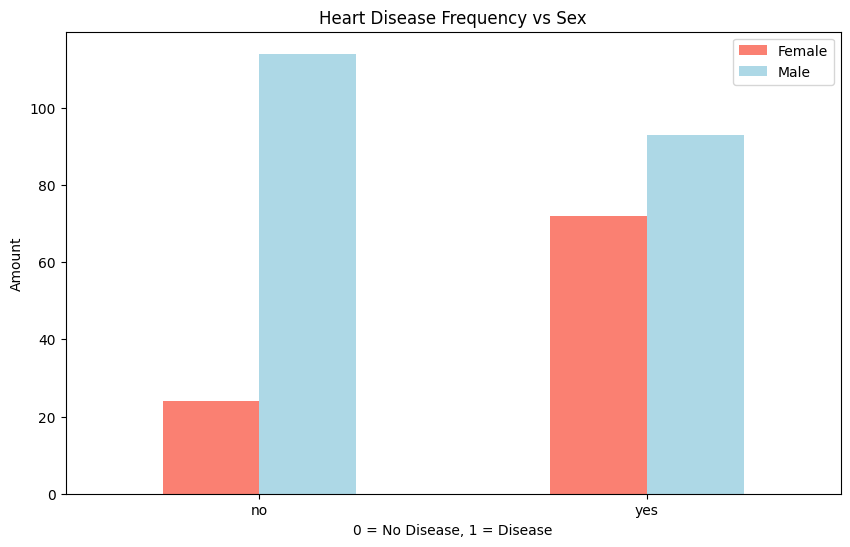

In [145]:
# Create a plot
pd.crosstab(df.target, df.sex).plot(kind="bar", figsize=(10,6), color=["salmon", "lightblue"])

# Add some attributes to it
plt.title("Heart Disease Frequency vs Sex")
plt.xlabel("0 = No Disease, 1 = Disease")
plt.ylabel("Amount")
plt.legend(["Female", "Male"])
plt.xticks(rotation=0); # keep the labels on the x-axis vertical

Let's try combining a couple of independent variables, such as, age and thalach (maximum heart rate) and then comparing them to our target variable heart disease. Because there are so many different values for age and thalach, we'll use a scatter plot.

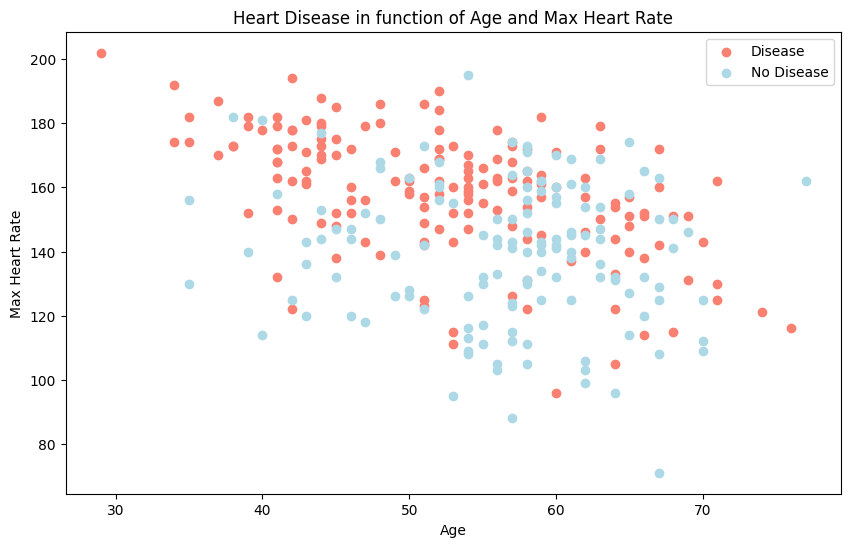

In [146]:
plt.figure(figsize=(10,6))

# Start with positive examples
plt.scatter(df.age[df.target == 'yes'],
            df.thalach[df.target == 'yes'],
            c="salmon", label="Disease")  # Use label here instead of plt.legend()

# Now for negative examples
plt.scatter(df.age[df.target == 'no'],
            df.thalach[df.target == 'no'],
            c="lightblue", label="No Disease")

# Add labels
plt.title("Heart Disease in function of Age and Max Heart Rate")
plt.xlabel("Age")
plt.ylabel("Max Heart Rate")
plt.legend()  # This automatically uses labels from scatter()


It seems the younger someone is, the higher their max heart rate (dots are higher on the left of the graph) and it seems there may be more heart disease in the younger population too (more orange dots). Let's check the age distribution.

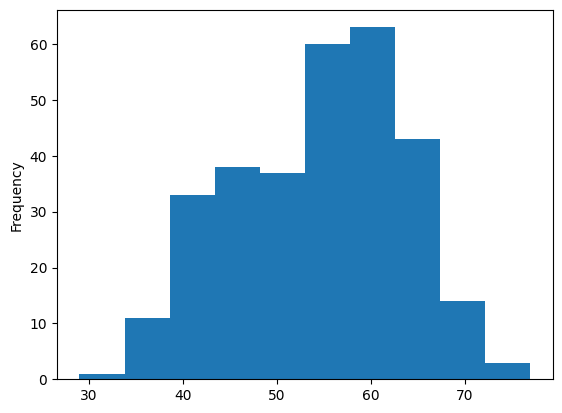

In [147]:
# Histograms are a great way to check the distribution of a variable
df.age.plot.hist();

We can see it's a normal distribution but slightly swaying to the right, which reflects in the scatter plot above.

This time, we'll use cp (chest pain) as the independent variable.

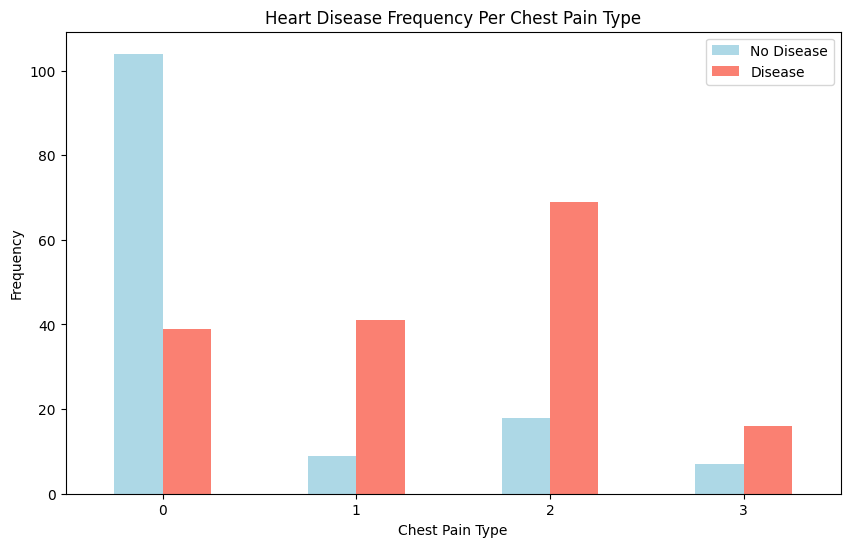

In [148]:
# Create a new crosstab and base plot
pd.crosstab(df.cp, df.target).plot(kind="bar",
                                   figsize=(10,6),
                                   color=["lightblue", "salmon"])

# Add attributes to the plot to make it more readable
plt.title("Heart Disease Frequency Per Chest Pain Type")
plt.xlabel("Chest Pain Type")
plt.ylabel("Frequency")
plt.legend(["No Disease", "Disease"])
plt.xticks(rotation = 0);

We would move on to find the correlations among all independent variables with target column. But first we need to change categorical column into numerical column. And also fix columns with null values.

In [149]:
df['sex'] = df['sex'].map({'male': 1, 'female': 0})

In [150]:
df['target'] = df.target.map({'yes': 1, 'no': 0})

In [151]:
columns_to_fill = ['trestbps', 'chol', 'thalach']
for col in columns_to_fill:
    df[col] = df[col].fillna(df[col].median())

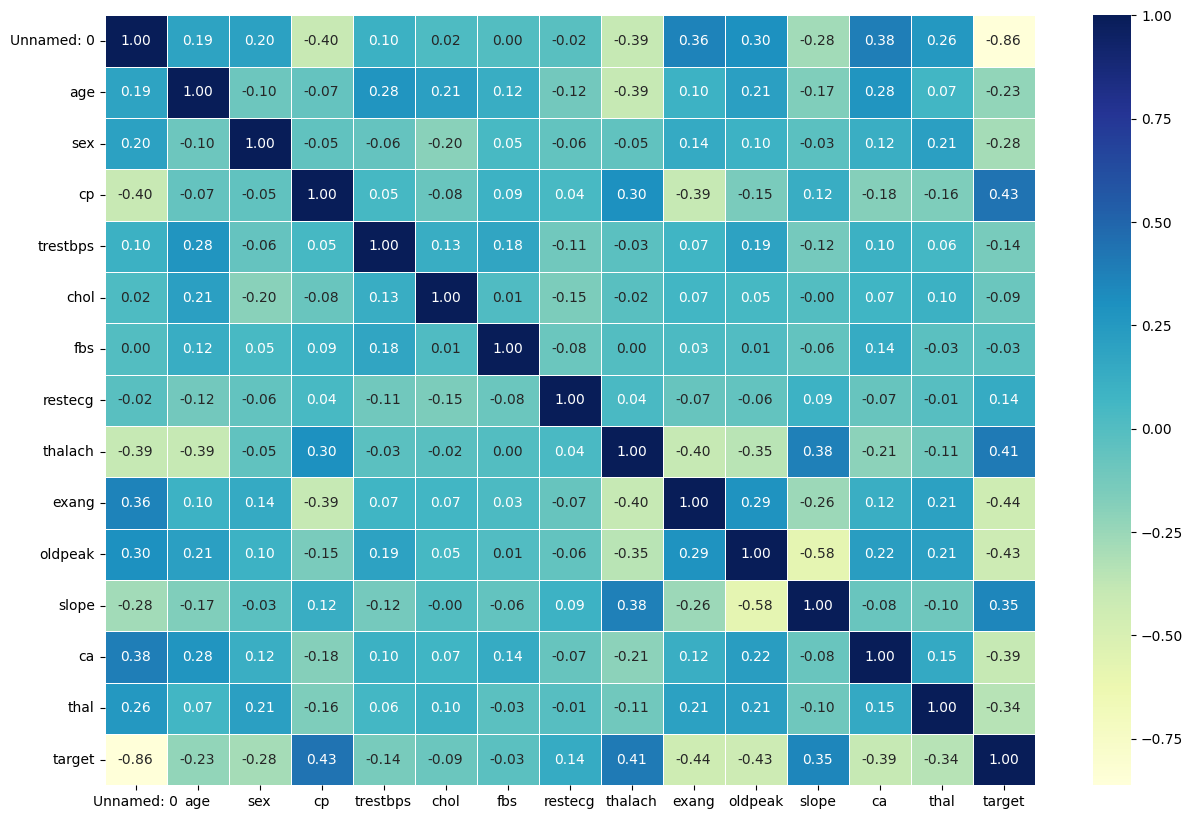

In [152]:
# Let's make it look a little prettier
corr_matrix = df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix,
            annot=True,
            linewidths=0.5,
            fmt= ".2f",
            cmap="YlGnBu");

### 5.4 Modelling

In [153]:
# split into explaining and target variables
# Everything except target variable
X = df.drop(labels="target", axis=1)

# Target variable
y = df.target.to_numpy()

# Independent variables (no target column)
X.head()

,Unnamed: 0,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,0,63,1,3,145.0,233.0,1,0,150.0,0,2.3,0,0,1
1,1,37,1,2,130.0,250.0,0,1,187.0,0,3.5,0,0,2
2,2,41,0,1,130.0,204.0,0,0,172.0,0,1.4,2,0,2
3,3,56,1,1,120.0,236.0,0,1,178.0,0,0.8,2,0,2
4,4,57,0,0,130.0,354.0,0,1,163.0,1,0.6,2,0,2


In [154]:
# Targets (in the form of a NumPy array)
y, type(y)

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [155]:
# split into training and testing dataset
# Random seed for reproducibility (since train_test_split is random by default, setting the seed will create reproducible splits)
np.random.seed(42)

# Split into train & test set
X_train, X_test, y_train, y_test = train_test_split(X, # independent variables
                                                    y, # dependent variable
                                                    test_size = 0.2) # percentage of data to use for test set

In [156]:
y_train, len(y_train)

(array([1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
        1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
        0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
        1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
        1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
        1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
        0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1]),
 242)

In [157]:
y_test, len(y_test)

(array([0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
        0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0]),
 61)

In [158]:
X_train.head()

,Unnamed: 0,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
132,132,42,1,1,120.0,295.0,0,1,162.0,0,0.0,2,0,2
202,202,58,1,0,150.0,270.0,0,0,111.0,1,0.8,2,0,3
196,196,46,1,2,150.0,231.0,0,1,147.0,0,3.6,1,0,2
75,75,55,0,1,135.0,250.0,0,0,161.0,0,1.4,1,0,2
176,176,60,1,0,117.0,230.0,1,1,160.0,1,1.4,2,2,3


In [159]:
X_test.head()

,Unnamed: 0,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
179,179,57,1,0,150.0,276.0,0,0,112.0,1,0.6,1,1,1
228,228,59,1,3,170.0,288.0,0,0,159.0,0,0.2,1,0,3
111,111,57,1,2,150.0,126.0,1,1,173.0,0,0.2,2,1,3
246,246,56,0,0,134.0,409.0,0,0,150.0,1,1.9,1,2,3
60,60,71,0,2,110.0,265.0,1,0,130.0,0,0.0,2,1,2


Following [this map](https://scikit-learn.org/stable/machine_learning_map.html) from Sckitlearn, we will test out these following models:
- Logistic Regression
- K-Nearest Neighbors
- RandomForest

In [166]:
# Put models in a dictionary
models = {"KNN": KNeighborsClassifier(),
          "Logistic Regression": LogisticRegression(max_iter=100), # Note: if you see a warning about "convergence not reached", you can increase `max_iter` until convergence is reached
          "Random Forest": RandomForestClassifier()}

# Create function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of different Scikit-Learn machine learning models
    X_train : training data
    X_test : testing data
    y_train : labels assosciated with training data
    y_test : labels assosciated with test data
    """
    # Random seed for reproducible results
    np.random.seed(42)
    # Make a list to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [165]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)
model_scores

{'KNN': 0.9836065573770492, 'Logistic Regression': 1.0, 'Random Forest': 1.0}

Based on this accuracy score, let's go with simpler model: Logistic Regression.
## 6. Experimentation (optional in ML engineering, no need for this case)
Here's the plan:

- Tune model hyperparameters, and see which performs best
- Perform cross-validation
- Plot ROC curves
- Make a confusion matrix
- Get precision, recall and F1-score metrics
- Find the most important model features

### 6.1 Hyperparameter tuning

The difference between RandomizedSearchCV and GridSearchCV is:

- sklearn.model_selection.RandomizedSearchCV searches over a grid of hyperparameters performing n_iter combinations (e.g. will explore random combinations of the hyperparameters for a defined number of iterations).
- sklearn.model_selection.GridSearchCV will test every single possible combination of hyperparameters in the grid (this is a thorough test but can take quite a long time).
Each class will save the best model at the end of testing.

Tuning models with with RandomizedSearchCV

In [169]:
# Different LogisticRegression hyperparameters
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}

# Different RandomForestClassifier hyperparameters
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}


# Setup random seed
np.random.seed(42)

# Setup random hyperparameter search for LogisticRegression
rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                                param_distributions=log_reg_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True)

# Fit random hyperparameter search model
rs_log_reg.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [170]:
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 29.763514416313132}

In [171]:
rs_log_reg.score(X_test, y_test)

1.0

Tuning a model with GridSearchCV

In [172]:
# Different LogisticRegression hyperparameters
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}

# Setup grid hyperparameter search for LogisticRegression
gs_log_reg = GridSearchCV(LogisticRegression(),
                          param_grid=log_reg_grid,
                          cv=5,
                          verbose=True)

# Fit grid hyperparameter search model
gs_log_reg.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [173]:
# Check the best parameters
gs_log_reg.best_params_

{'C': 29.763514416313132, 'solver': 'liblinear'}

In [174]:
# Evaluate the model
gs_log_reg.score(X_test, y_test)

1.0

### 6.2 ROC Curve and AUC Scores

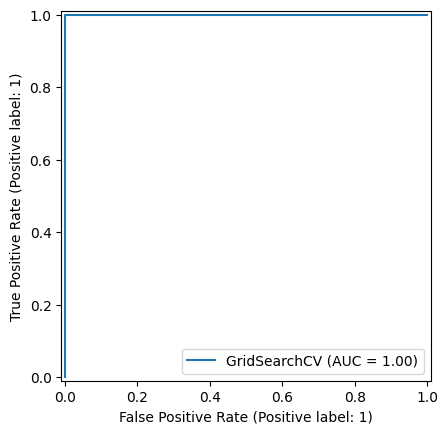

In [175]:
from sklearn.metrics import RocCurveDisplay

# from_estimator() = use a model to plot ROC curve on data
RocCurveDisplay.from_estimator(estimator=gs_log_reg,
                               X=X_test,
                               y=y_test);

### 6.3 Confusion matrix

In [177]:
# Make preidctions on test data
y_preds = gs_log_reg.predict(X_test)

In [178]:
# Display confusion matrix
print(confusion_matrix(y_test, y_preds))

[[29  0]
 [ 0 32]]


### 6.4 Classification report

In [179]:
# Show classification report
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        32

    accuracy                           1.00        61
   macro avg       1.00      1.00      1.00        61
weighted avg       1.00      1.00      1.00        61



### 6.5 Cross validation

In [181]:
# Check best hyperparameters
gs_log_reg.best_params_

{'C': 29.763514416313132, 'solver': 'liblinear'}

In [184]:
# Import cross_val_score
from sklearn.model_selection import cross_val_score

# Instantiate best model with best hyperparameters (found with GridSearchCV)
clf = LogisticRegression(C=29.763514416313132,
                         solver="liblinear")

In [185]:
# Cross-validated accuracy score
cv_acc = cross_val_score(clf,
                         X,
                         y,
                         cv=5, # 5-fold cross-validation, this is the default
                         scoring="accuracy") # accuracy as scoring
cv_acc

array([0.86885246, 1.        , 1.        , 1.        , 0.71666667])

In [186]:
cv_acc = np.mean(cv_acc)
cv_acc

0.917103825136612

In [187]:
# Cross-validated precision score
cv_precision = np.mean(cross_val_score(clf,
                                       X,
                                       y,
                                       cv=5, # 5-fold cross-validation
                                       scoring="precision")) # precision as scoring
cv_precision

0.9609756097560975

In [188]:
# Cross-validated recall score
cv_recall = np.mean(cross_val_score(clf,
                                    X,
                                    y,
                                    cv=5, # 5-fold cross-validation
                                    scoring="recall")) # recall as scoring
cv_recall

0.8969696969696969

In [189]:
# Cross-validated F1 score
cv_f1 = np.mean(cross_val_score(clf,
                                X,
                                y,
                                cv=5, # 5-fold cross-validation
                                scoring="f1")) # f1 as scoring
cv_f1

0.9089906232763376

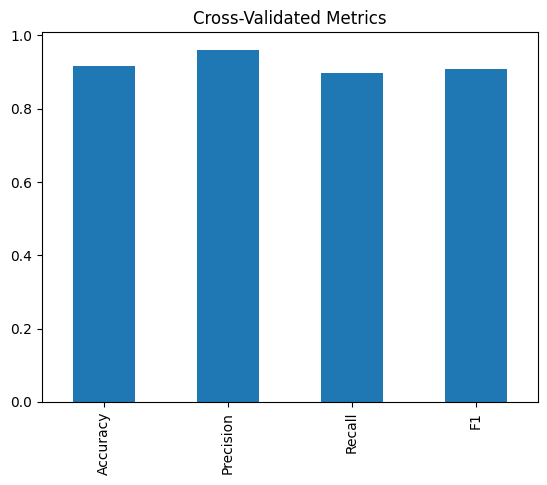

In [190]:
# Visualizing cross-validated metrics
cv_metrics = pd.DataFrame({"Accuracy": cv_acc,
                            "Precision": cv_precision,
                            "Recall": cv_recall,
                            "F1": cv_f1},
                          index=[0])
cv_metrics.T.plot.bar(title="Cross-Validated Metrics", legend=False);

### 6.7 Feature importance

In [191]:
# Fit an instance of LogisticRegression (taken from above)
clf.fit(X_train, y_train);

In [192]:
# Check coef_
clf.coef_

array([[-0.96890685,  0.71223437, -0.10857863, -0.20385402,  0.47521526,
        -0.06498215, -0.02455644,  1.70159405,  0.48467554,  0.04237282,
        -3.45656127,  0.86233529, -0.20267043,  0.11586317]])

In [193]:
# Match features to columns
features_dict = dict(zip(df.columns, list(clf.coef_[0])))
features_dict

{'Unnamed: 0': -0.968906845823987,
 'age': 0.7122343719300339,
 'sex': -0.10857862577020783,
 'cp': -0.20385402407327766,
 'trestbps': 0.4752152598372801,
 'chol': -0.06498215422539291,
 'fbs': -0.024556439282675875,
 'restecg': 1.7015940529961242,
 'thalach': 0.4846755389754044,
 'exang': 0.04237281781642417,
 'oldpeak': -3.4565612685646325,
 'slope': 0.8623352947724304,
 'ca': -0.20267042715107547,
 'thal': 0.11586316995163279}

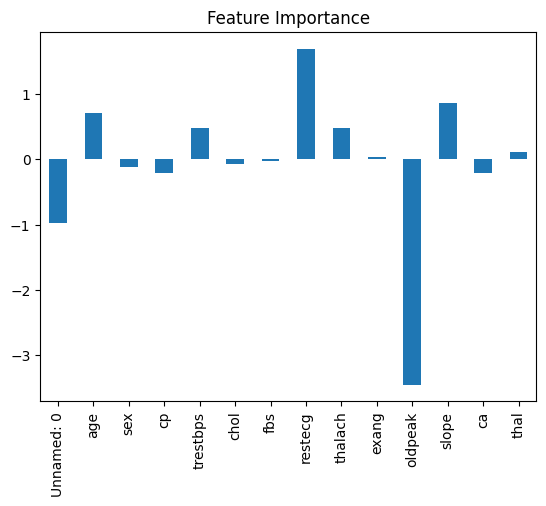

In [194]:
# Visualize feature importance
features_df = pd.DataFrame(features_dict, index=[0])
features_df.T.plot.bar(title="Feature Importance", legend=False);

The larger the value (bigger bar), the more the feature contributes to the models decision.

If the value is negative, it means there's a negative correlation. And vice versa for positive values.

For example, the sex attribute has a negative value of -0.10857862577020783, which means as the value for sex increases, the target value decreases.

We can see this by comparing the sex column to the target column.

In [195]:
pd.crosstab(df["sex"], df["target"])

target,0,1
sex,,
0,24,72
1,114,93


You can see, when sex is 0 (female), there are almost 3 times as many (72 vs. 24) people with heart disease (target = 1) than without.

And then as sex increases to 1 (male), the ratio goes down to almost 1 to 1 (114 vs. 93) of people who have heart disease and who don't.

In [196]:
# Contrast slope (positive coefficient) with target
pd.crosstab(df["slope"], df["target"])

target,0,1
slope,,
0,12,9
1,91,49
2,35,107


Looking back the data dictionary, we see slope is the "slope of the peak exercise ST segment" where:

- 0: Upsloping: better heart rate with excercise (uncommon)
- 1: Flatsloping: minimal change (typical healthy heart)
- 2: Downslopins: signs of unhealthy heart

According to the model, there's a positive correlation of 0.8623352947724304. This positive correlation means our model is picking up the pattern that as slope increases, so does the target value. When you look at the contrast (pd.crosstab(df["slope"], df["target"]) it is. As slope goes up, so does target.